# Asset Pricing 2: Homework 2

### Trent Potter

### Winter 2025
--- 
### **Analysis of Market-Timing Strategy Performance Across Rolling Windows**

The results of the market-timing strategy across different rolling-window sizes reveal several interesting patterns:

| $ w $  | Sharpe Ratio | Information Ratio |
|----------|-------------|-------------------|
| 3        | -0.0531     | 0.0482            |
| 12       | -0.0306     | 0.0276            |
| 60       | 0.1629      | 0.0241            |
| 120      | 0.4415      | 0.4263            |
| **Market (aligned with $ w=3 $)** | **0.1416** | **NA** |
| **Momentum (aligned with $ w=3 $)** | **0.1901** | **0.2382** |

#### **Interpreting the Results** (Questions 1 & 2)
The first notable observation is that **shorter rolling windows ($ w = 3, 12, 60 $) result in poor Sharpe and Information Ratios, while the long-term strategy ($ w = 120 $) performs well.** 

1. **Negative Sharpe Ratios for $ w = 3 $ and $ w = 12 $ Are Surprising:**  
   - Given that we are not trading derivatives (where expected payoffs and variance are linear in position size), I would expect that a strategy should at worst yield an expected zero return rather than a negative one.
   - If the market-timing expected returns are negative on average, this suggests that simply inverting the strategy might yield a positive Sharpe Ratio.  The root cause in this case seems to be a near zero expected return (within one std error of zero). 

2. **Higher Information Ratio for $ w = 3 $ Than for $ w = 12 $ and $ w = 60 $:**  
   - The information ratio remains positive, even for strategies with negative Sharpe Ratios.  
   - Notably, $ w = 3 $ has a higher information ratio than both $ w = 12 $ and $ w = 60 $, suggesting that the inferential power of the model is high despite poor trading performance.
   - This aligns with the discussion in *The Virtue of Complexity in Return Prediction*, which highlights that models with high covariate-to-observation ratios capture more information but often fail due to excess statistical bias and variance in inference.
   - The fact that the information ratio remains relatively strong suggests that the model is indeed capturing structure in returns (shown in later section), but the bias and variance introduced in inference lower the total Sharpe.  
   - Regularization techniques, as discussed in the paper, could reduce statistical bias and variance to improve out-of-sample performance.

3. **Strong Performance for $ w = 120 $ (10-Year Window) Is Economically Sensible:**  
   - The 120-month rolling regression exhibits both the highest Sharpe Ratio (0.4415) and the highest Information Ratio (0.4263)**, indicating market-timing ability.  
   - A long $ w $ provides more stable and meaningful coefficient estimates alongside more variation in each of the covariates.  
   - This aligns with economic intuition—long-term risk premia are more predictable than short-term fluctuations, which are often driven by transient noise.
   - The superior performance of $ w = 120 $ suggests that persistent long-term factors explain a meaningful portion of excess returns, which a short-term model (with high variance in coefficient estimates) struggles to capture.

4. **Comparison to Market and Momentum Strategies:**  
   - The **market Sharpe Ratio (0.1416)** serves as a benchmark. The market-timing strategy underperforms for small $ w $, but $ w = 120 $ significantly outperforms.  
   - The **momentum strategy (Sharpe = 0.1901, IR = 0.2382)** outperforms the market and most rolling-window strategies except $ w = 120 $.  
   - This suggests that **momentum captures a persistent short-term signal**, whereas rolling-window regression struggles with short-horizon predictability.

#### **Analysis of $y$ weights** (Questions 3 & 4)

Looking at the weight structure:

$$
x_t (X^T X)^+X^T
$$

we see that the weights on the lagged $ y $ values center over time with significant structure. Given that we’re dealing with a high-dimensional regression problem (more covariates than observations), this is notable since we might have expected much noisier, unstable weights.  The AR model rougly corresponds to 

A few key structural properties of our predictors explain this stability:

##### High Collinearity Across Predictors

The 10-year moving averages are highly overlapping, meaning each predictor is strongly correlated with its neighbors.

This redundancy in information could make $ X^T X $ ill-conditions, as some of the eigen values dominate.

##### Persistence Over Time

Because we use long-horizon moving averages, our predictors change gradually, leading to a slow-moving structure in $ X $ potentially leading to better out of sample performance.

##### Source of Variance

Looking at the Moore-Penrose inverse, we have that:

$$
\beta = X^+y + \left[I - X^+X\right]w
$$

for non full column rank matracies when solving least squares.  We've got an additional source of variance in our $\beta$ estimate.  I believe this is what we'll be able to reduce via shrinkage mechanisms.

In [496]:
import pandas as pd
import numpy as np

# Read the Excel file
df = pd.read_excel('CRSPMonthly.xlsx')
df["re"] = df["rvwind"] - df["rf"]
# Display the first few rows of the dataframe
df.head()

,month,rvwind,rf,re
0,1927-01-01,0.002416,0.0025,-0.000084
1,1927-02-01,0.045370,0.0026,0.042770
2,1927-03-01,0.003756,0.0030,0.000756
3,1927-04-01,0.007225,0.0025,0.004725
4,1927-05-01,0.057773,0.0030,0.054773


In [497]:
# Create predictor vars
# add a constant
df['const'] = 1

# 120 month lag, aligned s.t. the first observation is the 121st month (i.e. R[t] ~ R[t-120:t-1]+1)
df[f'lag_0'] = df['re'].rolling(window=120).mean().shift(1)

# Create the remaining predictors
for i in range(1,20):
  df[f'lag_{i}'] = df['lag_0'].shift(i*12)

# axe rows without all lags
df = df[19*12+120:]
df.reset_index(drop=True, inplace=True)

# helpful later
predictor_columns = ['const'] + [f'lag_{i}' for i in range(20)]


In [498]:
df

,month,rvwind,rf,re,const,lag_0,lag_1,lag_2,lag_3,lag_4,...,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19
0,1956-03-01,0.068456,0.0015,0.066956,1,0.011421,0.012007,0.010987,0.011653,0.013242,...,0.008272,0.010591,0.007580,0.013261,0.009751,0.005065,0.003820,0.002173,0.003368,0.008177
1,1956-04-01,0.005083,0.0019,0.003183,1,0.011499,0.012319,0.011087,0.011018,0.014159,...,0.008685,0.010564,0.007749,0.013500,0.010142,0.005678,0.003382,0.001261,0.000652,0.008147
2,1956-05-01,-0.049309,0.0023,-0.051609,1,0.011175,0.011931,0.011579,0.010716,0.014104,...,0.009716,0.010460,0.007763,0.010283,0.011283,0.006070,0.003578,0.001132,0.001521,0.007477
3,1956-06-01,0.037251,0.0020,0.035251,1,0.010413,0.011870,0.011418,0.010285,0.013868,...,0.009616,0.010322,0.008788,0.008983,0.013505,0.007303,0.001876,0.002241,0.001075,0.006956
4,1956-07-01,0.050830,0.0022,0.048630,1,0.011031,0.012376,0.011038,0.009992,0.013972,...,0.009088,0.009878,0.009049,0.008015,0.013755,0.006627,0.003788,0.000991,0.003460,0.006803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,2021-08-01,0.027147,0.0000,0.027147,1,0.011146,0.009989,0.010366,0.008480,0.006429,...,0.003029,-0.000292,-0.000917,0.001758,0.003624,0.005515,0.006035,0.006291,0.005302,0.004871
786,2021-09-01,-0.042244,0.0000,-0.042244,1,0.011853,0.010916,0.009922,0.008641,0.006374,...,0.003065,-0.001233,-0.000540,0.003187,0.004022,0.005452,0.005922,0.005980,0.005196,0.005120
787,2021-10-01,0.064658,0.0000,0.064658,1,0.012210,0.009860,0.009664,0.009463,0.006251,...,0.003142,-0.000001,0.000058,0.001863,0.003885,0.005175,0.005719,0.006325,0.005130,0.004194
788,2021-11-01,-0.018347,0.0000,-0.018347,1,0.011797,0.009371,0.010046,0.010377,0.006215,...,0.003880,0.000570,-0.000661,-0.000277,0.004396,0.005372,0.005656,0.006375,0.005495,0.004734


In [499]:
def ridgeless_regression(Y: pd.DataFrame, X: pd.DataFrame) -> pd.Series:
    beta = np.linalg.pinv(X.T@X)@X.T@Y
    return beta

In [500]:
def rolling_window_regression(df, w):

    # Function to apply within each rolling window
    def apply_regression(x) -> pd.Series:
        # Ensure x is reshaped into a DataFrame for indexing
        # x_df = pd.DataFrame(x, columns=numeric_df.columns)
        Y = x['re']
        X = x.loc[:, predictor_columns]
        # return pd.Series(ridgeless_regression(Y, X),name=x.index[-1])
        res: pd.Series = ridgeless_regression(Y, X).set_axis(X.columns, axis='index')
        return res

    # Apply rolling regression
    rolling_betas = df.groupby(df.index//w).apply(apply_regression)

    reindex = (rolling_betas.index+1)*w
    reindex = np.minimum(reindex, df.index.max())
    rolling_betas.set_index(reindex,inplace=True)
    # drop beta calculation that doesn't have full 'w' sized sample at end
    rolling_betas.drop(rolling_betas.index[-1], inplace=True)

    return rolling_betas

def calc_rets(betas, df):
  # reindex so we're using \beta[t] to predict R[t+1]
  exp_ret = (df.loc[betas.index, predictor_columns] * betas).sum(axis=1)
  rets=df.loc[exp_ret.index, 're']
  mkt_timing_ret = exp_ret*rets
  return mkt_timing_ret

def sharpe_ratio(returns, w):
  return returns.mean()  * np.sqrt(12) / returns.std()  

def information_ratio(strat_rets, mkt_rets, w):
  import statsmodels.api as sm

  X = sm.add_constant(mkt_rets)
  mkt_beta = np.linalg.pinv(X.T@X)@X.T@strat_rets
  over_mkt_rets = strat_rets - mkt_beta[1]*mkt_rets
  over_mkt_rets = over_mkt_rets.round(10)
  return sharpe_ratio(over_mkt_rets, w)


In [501]:
results ={
    'w': [3,12,60,120],
    'sharpe_ratio': [],
    'information_ratio': [],
    'betas' : [],
    'rets' : []
}
for w in results['w']:
  betas = rolling_window_regression(df,w)
  rets = calc_rets(betas, df)
  results['rets'].append(rets)
  results['betas'].append(betas)
  results['sharpe_ratio'].append(sharpe_ratio(rets, w))
  results['information_ratio'].append(information_ratio(rets, df.loc[rets.index,'re'], w))
  
qrtly_index = [i for i in range(3, len(df),3)]

market_rets = df.loc[qrtly_index, 're']

momentum_rets = (df['re']*df['re'].shift(1))[qrtly_index]


results['w'].append('market (aligned with w=3)')
results['rets'].append(market_rets)
results['betas'].append('NA')
results['sharpe_ratio'].append(sharpe_ratio(market_rets, 3))
results['information_ratio'].append("NA")

results['w'].append('momentum (aligned with w=3)')
results['rets'].append(momentum_rets)
results['betas'].append('NA')
results['sharpe_ratio'].append(sharpe_ratio(momentum_rets, 3))
results['information_ratio'].append(information_ratio(momentum_rets, market_rets, 3))

display(pd.DataFrame(results).set_index('w').drop(['rets','betas'], axis=1))

,sharpe_ratio,information_ratio
w,,
3,0.252065,0.352342
12,-0.409353,-0.309151
60,0.509886,-0.061078
120,-1.661725,0.457438
market (aligned with w=3),0.234879,NA
momentum (aligned with w=3),0.309799,0.393086


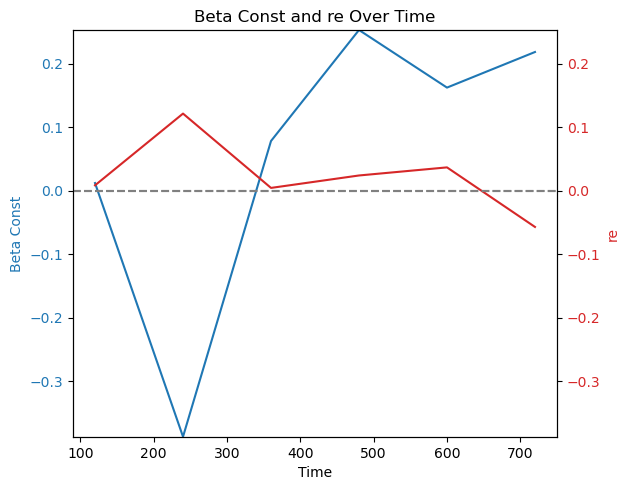

In [377]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.set_xlabel('Time')
ax1.set_ylabel('Beta Const', color='tab:blue')
ax1.plot(betas.index, betas['const'], color='tab:blue', label='Beta Const')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('re', color='tab:red')
ax2.plot(df.loc[betas.index].index, df.loc[betas.index, 're'], color='tab:red', label='re')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Set the same y-axis limits for both plots
ax1.set_ylim(min(betas['const'].min(), df.loc[betas.index, 're'].min()), 
       max(betas['const'].max(), df.loc[betas.index, 're'].max()))
ax2.set_ylim(ax1.get_ylim())

# Add a y=0 dashed line
ax1.axhline(0, color='gray', linestyle='--')
ax2.axhline(0, color='gray', linestyle='--')

fig.tight_layout()
plt.title('Beta Const and re Over Time')
plt.show()

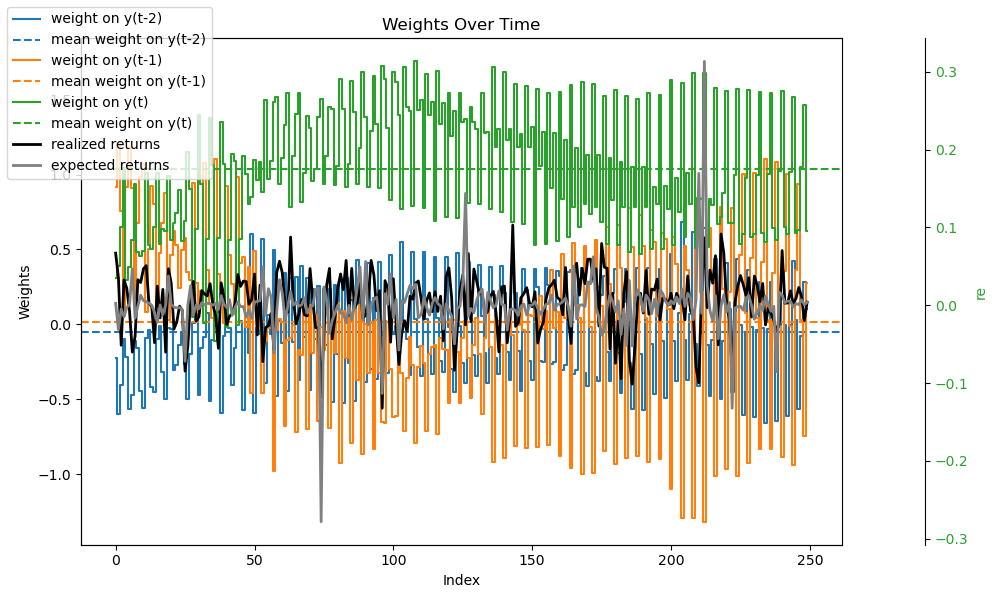

In [411]:
w=3
  

def partial_weights(df):
  X = df.loc[:, predictor_columns].values
  return np.linalg.pinv(X.T@X)@X.T

result = df.groupby(df.index//w).apply(partial_weights)
weights=[]
for idx, partial_weight in result.items():
  if idx+1 >= len(df)//w:
    break
  weight = df.loc[(idx+1)*w, predictor_columns] @ partial_weight
  weights.append(weight)
  
weights = np.vstack(weights)

start, stop = 0 , 250

returns = df.loc[qrtly_index,'re'].reset_index(drop=True)
expected_returns = results['rets'][0].reset_index(drop=True)
expected_returns = expected_returns/expected_returns.std()*returns.std()

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.step(range(len(weights[start:stop])), weights[start:stop, 0], label='weight on y(t-2)', where='mid')
ax1.axhline(weights[start:stop, 0].mean(), color='tab:blue', linestyle='--', label='mean weight on y(t-2)')
ax1.step(range(len(weights[start:stop])), weights[start:stop, 1], label='weight on y(t-1)', where='mid')
ax1.axhline(weights[start:stop, 1].mean(), color='tab:orange', linestyle='--', label='mean weight on y(t-1)')
ax1.step(range(len(weights[start:stop])), weights[start:stop, 2], label='weight on y(t)', where='mid')
ax1.axhline(weights[start:stop, 2].mean(), color='tab:green', linestyle='--', label='mean weight on y(t)')
ax1.set_xlabel('Index')
ax1.set_ylabel('Weights')
ax1.set_title('Weights Over Time')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('re', color='tab:green')
ax3.plot(returns[start:stop], label='realized returns', color='black', linewidth=2)
ax3.plot(expected_returns[start:stop], label='expected returns', color='grey', linewidth=2)
ax3.tick_params(axis='y', labelcolor='tab:green')

fig.tight_layout()
fig.legend(loc='upper left')
plt.show()

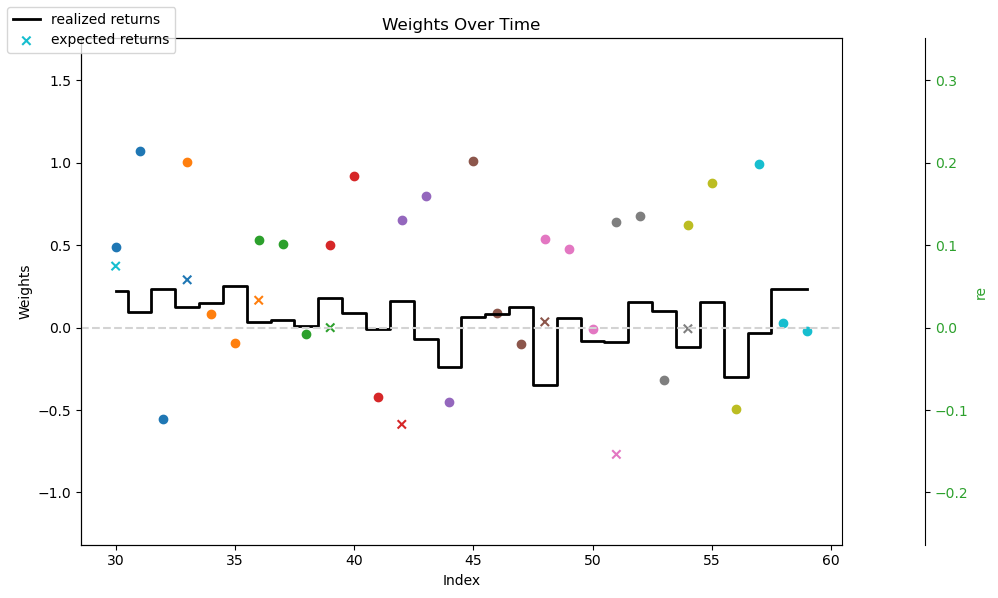

In [420]:
start, stop =10 , 20

flat_weights = weights[:, ::-1].flatten()

returns = df.loc[:,'re']
expected_returns = results['rets'][0] 
expected_returns = expected_returns / expected_returns.std() / 2
fig, ax1 = plt.subplots(figsize=(10, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
for i in range(start, stop):
  ax1.scatter(range(i*3, (i+1)*3), flat_weights[i*3:(i+1)*3], color=colors[i % len(colors)])

ax1.set_xlabel('Index')
ax1.set_ylabel('Weights')
ax1.set_title('Weights Over Time')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('re', color='tab:green')
ax3.step(range(start*w, stop*w), returns[start*w:stop*w], label='realized returns', color='black', linewidth=2, where='mid')

pred_colors = (colors*(stop//len(colors)+2))[start+9:stop+9]
ax3.scatter(range(start*w, stop*w, w), expected_returns[start:stop], label='expected returns', color=pred_colors, marker='x')
ax3.tick_params(axis='y', labelcolor='tab:green')

# Set the same y-axis limits for both plots
ax1.set_ylim(min(flat_weights.min(), returns.min()), max(flat_weights.max(), returns.max()))
ax1_bounds = ax1.get_ylim()
ax3.set_ylim(ax1_bounds[0]/5, ax1_bounds[1]/5)

ax3.axhline(0, color='lightgrey', linestyle='--')
fig.tight_layout()
fig.legend(loc='upper left')
plt.show()

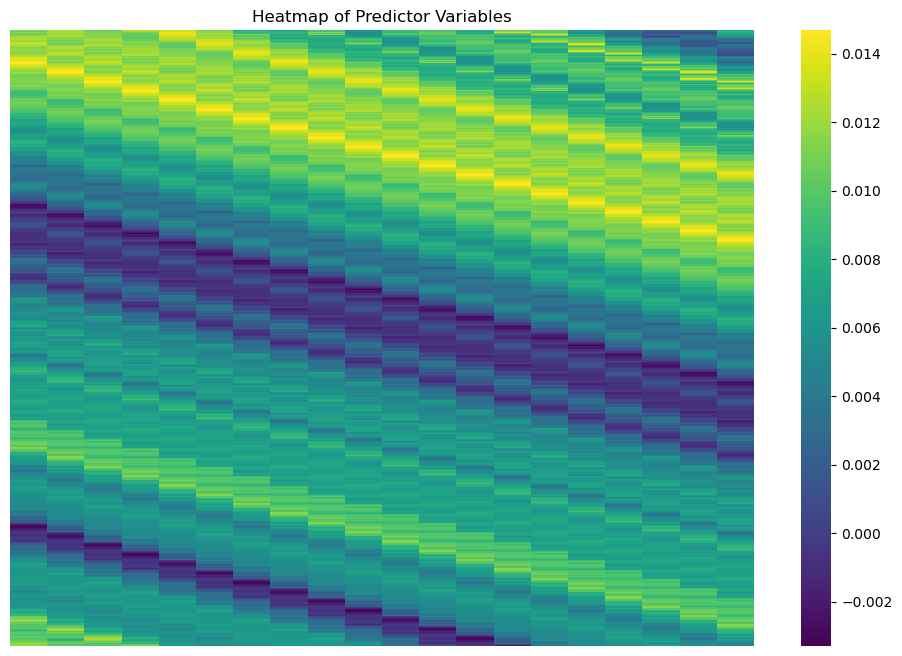

In [382]:
import seaborn as sns

X = df.loc[:, predictor_columns].values
X
plt.figure(figsize=(12, 8))
sns.heatmap(X[:,1:], cmap='viridis', cbar=True, xticklabels=False, yticklabels=False)
plt.title('Heatmap of Predictor Variables')
plt.show()

In [383]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
"""
This script calculates the Variance Inflation Factor (VIF) for each predictor variable in a dataset.

Variance Inflation Factor (VIF) is a measure of multicollinearity in a set of multiple regression variables. 
It quantifies how much the variance of a regression coefficient is inflated due to collinearity with other predictors.

Parameters:
- predictor_columns (list): A list of predictor variable names.
- X (DataFrame): A DataFrame containing the predictor variables.

Returns:
- vif_data (DataFrame): A DataFrame containing the VIF values for each predictor variable.

Interpretation of VIF:
- VIF = 1: No correlation between the predictor variable and the other variables.
- 1 < VIF < 5: Moderate correlation, but not severe enough to require corrective measures.
- VIF >= 5: High correlation, indicating multicollinearity. This suggests that the predictor variable is highly collinear with other variables, and corrective measures may be needed, such as removing the variable or combining it with others.
"""

# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["feature"] = predictor_columns
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

print(vif_data)

   feature        VIF
0    const  12.715871
1    lag_0   6.810778
2    lag_1  11.370093
3    lag_2  11.980354
4    lag_3  11.727345
5    lag_4  11.133310
6    lag_5  11.530106
7    lag_6  11.552974
8    lag_7  10.893189
9    lag_8  10.593147
10   lag_9  10.111887
11  lag_10  11.047340
12  lag_11  11.925934
13  lag_12  11.325375
14  lag_13  10.298436
15  lag_14   8.689386
16  lag_15   8.677627
17  lag_16   8.661511
18  lag_17   8.034090
19  lag_18   8.094938
20  lag_19   5.048891


In [384]:
import numpy as np

# Assume X is our predictor matrix
XtX = X.T @ X

# Compute eigenvalues
eigenvalues = np.linalg.eigvalsh(XtX)

# Compute condition number
condition_number = max(eigenvalues) / min(eigenvalues)
print("Condition Number:", condition_number)
print("Eigenvalues:", eigenvalues)


Condition Number: 2141510.8343883157
Eigenvalues: [  0.      0.      0.      0.001   0.001   0.001   0.001   0.001   0.001
   0.001   0.002   0.002   0.003   0.004   0.004   0.005   0.006   0.014
   0.076   0.115 792.66 ]


Thoughts on pinv:

- can solve via SVD -> $A = U \Sigma V^T$ then $A^+ = V \Sigma^{-1} U^T$
- if $A = X^T X$ -> SVD: $X^T X = U \Sigma^2 U^T$ -> $U^T \Sigma^{-2} U$
- Cov is well conditioned if we have a small eigen values / singular values in covariates

